# <a>Introdução</a>

* **Linguagem de Processamento Natural (Natural Language Processing - NLP)**
* **Sentimentos do DataSet:** Para a realização da análise de sentimento foi escolhido um DataSet na categoria **Política** onde esses dados foram classificados através de Querys na categoria política brasileira e realizando sua classificação de sentimentos através do Emoji (Smile - sentimento Positivo, Sad - Sentimento Negativo) minerados do Twitter em 2018 obtidos no Kaggle com sua classificação. 

## <a>Sumário</a>
1. [Importando bibliotecas](#p1)
2. [Importando DataDet](#p2)
3. [Análise Exploratória do DataSet](#p22)
3. [Pré Processamento do Texto](#p3)
4. [Análise dos dados](#p4)
5. [Splitting data](#p5)
6. [Vetorização TF-IDF](#p6)
7. [Transformação para vertor](#p7)
8. [Avalização de modelos](#p8)
    * [Modelo MultinomialNB](#p8-1)
    * [Modelo BernoulliNB](#p8-2)
    * [Modelo LinearSVC](#p8-3)
9. [Salvando modelos](#p9)
10. [Usando os modelos](#p10)
11. [Considerações](#p11)

## <a name="p1">Importando Bibliotecas</a>

In [86]:
# Documentos
import re
import pickle
import numpy as np
import pandas as pd
import unicodedata
import random
import nltk

# Plotagem
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.probability import FreqDist

# NLTK
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize

# SKLEARN
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

## <a name="p2">Importando DataSet</a>
O DataSet utilizado foi encontrado no Kaggle onde os sentimentos já foram definidos inicialmente. 

**Verificando de que forma o DataSet está distribuído:**
1. **id**: Identificação do tweet.
2. **tweet_text**: Texto publicado.
3. **tweet_data**: Data da publicação.
4. **sentiment**: Sentimento classificado **{0: 'Negativo', 1: 'Positivo', 2: 'Neutro'}**.
5. **query_used**: Query utilizada para realizar o DataMining em relação do texto publicado (tweet_text).

No primeiro momento estamos descartando as demais colunas coletadas.

In [2]:
# Importação do DataSet
dataset = pd.read_csv('C:/Users/Hugo Mauad/Desktop/Nova pasta/TrainingDatasets/TrainTema.csv', delimiter=';', encoding='utf-8')
dataset

,id,tweet_text,tweet_date,sentiment,query_used
0,1055282337313890305,@BabozeirasDaTv @aliviavasconc @Haddad_Fernand...,Thu Oct 25 02:18:10 +0000 2018,1,@haddad_fernando :)
1,1055279466438688768,@TelesPonte @rei_da_selfie @TCelTito @metal_th...,Thu Oct 25 02:06:45 +0000 2018,1,@jairbolsonaro :)
2,1055277276957421569,No ultimo podcast Café Brasil (um dos maiores ...,Thu Oct 25 01:58:03 +0000 2018,1,eleicao :)
3,1055275644576251904,@zelune @Haddad_Fernando @jairbolsonaro PARABÉ...,Thu Oct 25 01:51:34 +0000 2018,1,@haddad_fernando :)
4,1055271941626564609,@ManuelaDavila Nunca vi tanto passa-fome junto :),Thu Oct 25 01:36:51 +0000 2018,1,@manueladavila :)
...,...,...,...,...,...
49995,1035744942646280192,o Lula :(,Sat Sep 01 04:23:32 +0000 2018,0,lula :(
49996,1035742098761371653,":( Por 6 a 1, TSE rejeita candidatura de Lula ...",Sat Sep 01 04:12:14 +0000 2018,0,lula :(
49997,1035741917680726016,mano o lula :(,Sat Sep 01 04:11:30 +0000 2018,0,lula :(
49998,1035738916861759488,"@controlt91 sim, vdd :( agora o melhorzinho qu...",Sat Sep 01 03:59:35 +0000 2018,0,ciro :(


####  Podemos observar que neste DataSet sua classificação foi extramente simples. Utilizaram Querys com nomes de políticos brasileiros e para realizar sua classificação de sentimentos através do Emoji (Smile - sentimento Positivo, Sad - Sentimento Negativo)

In [3]:
# Texto publicado no Twitter
X_col = 'tweet_text'
# Sentimento
y_col = 'sentiment' 

In [4]:
# Classificando corretamente da seguinte forma:
dataset[y_col] = dataset[y_col].map({0: 'Negativo', 1: 'Positivo', 2: 'Neutro'})

In [5]:
# Primeiramente vamos remover as linhas duplicadas baseadas no texto para uma melhor Visualização
dataframe = dataset.drop_duplicates(['tweet_text'], inplace=True)

In [6]:
# Criando um DataFrame, escolhendo nossas colunas de interesse e checando os dados
dataframe = dataset[['tweet_text','sentiment']]
dataframe.count()

tweet_text    49763
sentiment     49763
dtype: int64

# <a name="p22">Análise Exploratória do DataSet</a>

In [7]:
Classificacao = dataframe['sentiment']
Classificacao.count()

49763

In [8]:
Text = dataframe['tweet_text']
Text.count()

49763

In [9]:
temp = dataframe.groupby('sentiment').count()['tweet_text'].reset_index().sort_values(by='tweet_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,tweet_text
1,Positivo,24885
0,Negativo,24878


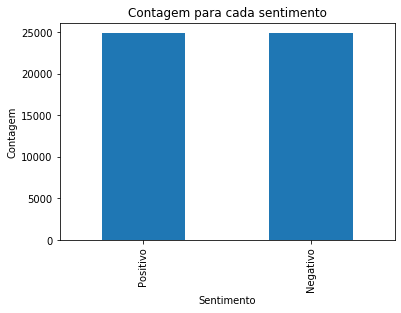

In [10]:
series = dataframe['sentiment'].value_counts()
ax = series.plot(kind='bar', title='Contagem para cada sentimento')
ax.set_xlabel('Sentimento')
ax.set_ylabel('Contagem')
plt.show()

# <a name="p3">Pré processamento do Texto</a>

**As etapas que serão realizadas para o pré processamento do texto**

1. **Replacing URLs:** Substituição de textos com **"http", "https", "www"**.
2. **Removing Emojis:** Substituição de um dicionário definido (**emojis**).
3. **Removing Usernames:** Substituição de **@Usernames**
4. **Removing Non-Alphabets and Normalization:** Substituição de não caracteres por " " ('Espaço') baseados na tabela da unicode data ASCII.
5. **Removing Consecutive letters:** Três ou mais letras consecutivas para apenas duas letras *(eg: "Oiiiiiii" para "Oii")*
6. **Removing Short Words:** Palavras com comprimento menor que 2 serão removidas.
7. **Tokenize:** Como o nome sugere, o tokenize utiliza uma expressão regular para determinar de que forma um texto deve ser dividido. Esta expressão regular define os caracteres que podem constituir uma palavra válida.
8. **Replace Abbreviations:** Substituições de algumas abreviações utilizadas no textos em português *(eg: "vc" para "você")
9. **Removing Stopwords:** Algumas palavras não agregam grandes significados em uma frase e definimos ela como **StopWords**, um dicionários com algumas stopwords em Português foi criado (**StopWordList**).
10. **Lemmatizing:** Retirar a conjugação verbal, caso seja um verbo, alterando os substantivos e os adjetivos para o singular masculino, de maneira a reduzir a palavra até sua forma de dicionário.
11. **Stemming:** Reduzindo para a sua palavra raíz (sem levar em conta a classe gramatical).

### <a>**Dicionários criados**</a>

In [11]:
# Definindo um dicionário contendo alguns emojis.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

# Definindo alguns StopWord em Português.
stopwordlist = ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'é', 'com', 'uma', 'os', 'no', 'se',
                'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'à', 'seu', 'sua', 'ou',
                'ser', 'quando', 'muito', 'há', 'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso',
                'ela', 'entre', 'era', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem', 'nas', 'me', 'esse', 'eles',
                'estão', 'você', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'têm', 'numa', 'pelos',
                'elas', 'havia', 'seja', 'qual', 'será', 'nós', 'tenho', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 
                'fosse', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso',
                'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas',
                'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava',
                'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos',
                'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'há', 'havemos', 'hão', 'houve', 'houvemos', 'houveram',
                'houvera', 'houvéramos', 'haja', 'hajamos', 'hajam', 'houvesse', 'houvéssemos', 'houvessem', 'houver', 'houvermos',
                'houverem', 'houverei', 'houverá', 'houveremos', 'houverão', 'houveria', 'houveríamos', 'houveriam', 'sou',
                'somos', 'são', 'era', 'éramos', 'eram', 'fui', 'foi', 'fomos', 'foram', 'fora', 'fôramos', 'seja', 'sejamos',
                'sejam', 'fosse', 'fôssemos', 'fossem', 'for', 'formos', 'forem', 'serei', 'será', 'seremos', 'serão', 'seria',
                'seríamos', 'seriam', 'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos', 'tinham', 'tive', 'teve', 'tivemos',
                'tiveram', 'tivera', 'tivéramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivéssemos', 'tivessem', 'tiver',
                'tivermos', 'tiverem', 'terei', 'terá', 'teremos', 'terão', 'teria', 'teríamos', 'teriam']

# Criando mais uma lista de abreviações
std_list = {'eh': 'é', 'vc': 'você', 'vcs': 'vocês','tb': 'também', 'tbm': 'também', 'obg': 'obrigado', 'gnt': 'gente', 'q': 'que',
            'n': 'não', 'cmg': 'comigo', 'p': 'para', 'ta': 'está', 'to': 'estou', 'vdd': 'verdade', 'pq': 'porque'}


### <a>**Removendo ruídos**</a>

In [12]:
def Replace_Normalization(textdata):
    processedText = []
 
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-ZÀ-ÖØ-öø-ÿ]" #Tabela ASCII 
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Substituindo todas as URls
        tweet = re.sub(urlPattern,' ',tweet)
        # Substituindo todos os emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, ' ')        
        # Substituindo @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' ', tweet)        
        # Normalização das palavras
        tweet = re.sub(alphaPattern, " ", tweet)
        # Subistituindo 3 ou mais palabras consecutivas.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            if len(word)>1:
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [13]:
Text = Replace_Normalization(Text)

### <a> **Tokenization** </a>

In [14]:
def _tokenize_text(data):
    ls = []

    for line in data:
        tokens = wordpunct_tokenize(line)
        ls.append(tokens)

    return ls

In [15]:
X_train_tokens = _tokenize_text(Text)

In [16]:
# Observando os dados
for i in range(0, 2):
    print(X_train_tokens[i])

['olha', 'ai', 'seu', 'candidato', 'que', 'sempre', 'trabalha', 'com', 'verdade', 'quer', 'passar', 'mais', 'vergonha', 'ou', 'deixar', 'para', 'amanhã']
['sabe', 'que', 'me', 'incomoda', 'mais', 'acima', 'de', 'tudo', 'que', 'já', 'falei', 'eu', 'não', 'ser', 'reconhecida', 'pelo', 'que', 'eu', 'amo', 'ele', 'viveu', 'os', 'anos', 'dele', 'até', 'agora', 'tem', 'vivido', 'do', 'jeito', 'que', 'ele', 'escolheu', 'sem', 'influência', 'tenho', 'direito', 'do', 'mesmo']


### <a>**Substituição de Abreviações**<a/>

In [17]:
def _apply_standardization(tokens, std_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            if word.lower() in std_list:
                word = std_list[word.lower()]
                
            new_tokens.append(word) 
            
        ls.append(new_tokens)

    return ls

In [18]:
X_train_tokens = _apply_standardization(X_train_tokens, std_list)

In [19]:
# Observando os dados
for i in range(6, 7):
    print(X_train_tokens[i])

['gente', 'desculpe', 'tava', 'off', 'prometo', 'ler', 'tudo', 'responder', 'com', 'educação', 'porque', 'aqui', 'tem', 'voto', 'consciente', 'tem', 'respeito', 'também']


### <a>**Removendo StopWords**</a>

In [20]:
def _remove_stopwords(tokens, stopwordlist):
    ls = []

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            if word.lower() not in stopwordlist:
                new_tokens.append(word) 
            
        ls.append(new_tokens)
        
    return ls

In [21]:
X_train_tokens = _remove_stopwords(X_train_tokens, stopwordlist)

In [22]:
# Observando os dados
for i in range(0, 2):
    print(X_train_tokens[i])

['olha', 'ai', 'candidato', 'sempre', 'trabalha', 'verdade', 'quer', 'passar', 'vergonha', 'deixar', 'amanhã']
['sabe', 'incomoda', 'acima', 'tudo', 'falei', 'não', 'reconhecida', 'amo', 'viveu', 'anos', 'agora', 'vivido', 'jeito', 'escolheu', 'influência', 'direito']


### <a> **Aplicando Lematization** </a>

In [23]:
from nltk.stem import WordNetLemmatizer
def _apply_lemmatization(tokens):
    ls = []
    lemmatization = WordNetLemmatizer()

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            word = str(lemmatization.lemmatize(word))
            new_tokens.append(word) 
            
        ls.append(new_tokens)
        
    return ls

In [24]:
X_train_tokens = _apply_lemmatization(X_train_tokens)

In [25]:
# Observando os dados
for i in range(0, 2):
    print(X_train_tokens[i])

['olha', 'ai', 'candidato', 'sempre', 'trabalha', 'verdade', 'quer', 'passar', 'vergonha', 'deixar', 'amanhã']
['sabe', 'incomoda', 'acima', 'tudo', 'falei', 'não', 'reconhecida', 'amo', 'viveu', 'ano', 'agora', 'vivido', 'jeito', 'escolheu', 'influência', 'direito']


### <a>**Aplicando Stemming**</a>

In [26]:
def _apply_stemmer(tokens):
    ls = []
    stemmer = nltk.stem.RSLPStemmer()

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            word = str(stemmer.stem(word))
            new_tokens.append(word) 
            
        ls.append(new_tokens)
        
    return ls

In [27]:
X_train_tokens = _apply_stemmer(X_train_tokens)

In [28]:
# Observando os dados
for i in range(0, 2):
    print(X_train_tokens[i])

['olh', 'ai', 'candidat', 'sempr', 'trabalh', 'verdad', 'qu', 'pass', 'vergonh', 'deix', 'amanhã']
['sab', 'incomod', 'acim', 'tud', 'fal', 'não', 'reconhec', 'amo', 'viv', 'ano', 'agor', 'viv', 'jeit', 'escolh', 'influ', 'direit']


# <a name="p4">Analisando os Dados</a>

### <a name="p4-1">WordClound</a>
Vamos analisar os dados não processados. Utilizando a visualização WordClound do DataSet

In [29]:
def _get_text_cloud(tokens):
    text = ''

    for tk_line in tokens:
        new_corpus_tokens = []
        
        for word in tk_line:
            text += word + ' '
        
    return text

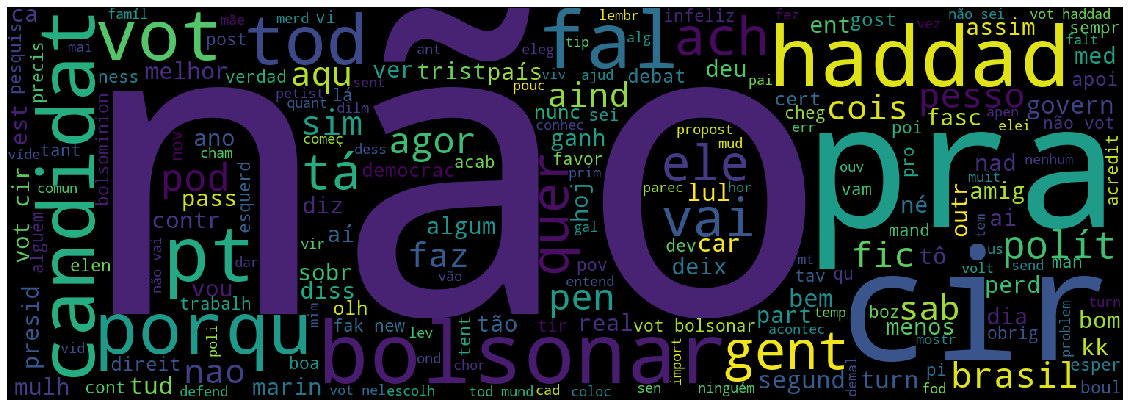

In [85]:
# print train WordCloud
sample_train = random.sample(X_train_tokens, 10000)
text_cloud = _get_text_cloud(sample_train)

word_cloud = WordCloud(max_font_size = 1000, width = 1520, height = 535)
word_cloud.generate(text_cloud)
plt.figure(figsize = (20, 20))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### <a name="p4-1">Distribuição de Frequência</a>

In [31]:
def _get_freq_dist_list(tokens):
    ls = []

    for tk_line in tokens:
        for word in tk_line:
            ls.append(word)
    
    return ls

In [32]:
# Distribuição da Frequência dos dados treinados no DataSet.
fd_list = _get_freq_dist_list(X_train_tokens)
fdist = FreqDist(fd_list)
print(fdist)

<FreqDist with 19564 samples and 601073 outcomes>


In [33]:
# Palavras mais comuns
most_common = fdist.most_common(25)
print(most_common)

[('não', 19517), ('vot', 9883), ('pra', 7757), ('cir', 7289), ('bolsonar', 7174), ('vai', 5475), ('haddad', 5430), ('candidat', 4844), ('quer', 4473), ('fal', 4435), ('pt', 4151), ('ele', 4142), ('porqu', 3820), ('tod', 3721), ('gent', 3604), ('polít', 3394), ('ach', 3393), ('faz', 3236), ('pod', 3173), ('tá', 2922), ('turn', 2806), ('fic', 2540), ('brasil', 2510), ('ganh', 2489), ('sab', 2416)]


In [34]:
# Palavras menos comuns (palabras que aparem apenas uma vez)
most_uncommon = fdist.hapaxes()
print(most_uncommon[0:30])

['heueheueh', 'exercíciodeinterpret', 'jairbolsonaropresid', 'retraç', 'hahahhahahahhahah', 'remanej', 'katiguir', 'bagr', 'dispendi', 'csralh', 'activ', 'afag', 'crom', 'tea', 'quisit', 'extracurricul', 'consequên', 'embol', 'carc', 'seuvotomepoeemrisc', 'definica', 'tomacag', 'icil', 'klu', 'normand', 'bolsonaroéocaralh', 'apach', 'partiucub', 'cadiqu', 'toom']


In [35]:
# A palavra que mais apareceu no DataSet
fdist.max()

'não'

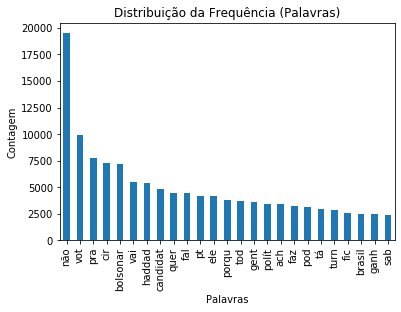

In [36]:
# Gráfico das palavras que mais apareceram no DataSet
series = pd.Series(data=[v for k, v in most_common], index=[k for k, v in most_common], name='')
ax = series.plot(kind='bar', title='Distribuição da Frequência (Palavras)')
ax.set_xlabel('Palavras')
ax.set_ylabel('Contagem')
plt.show()

### <a>**Untokenize Texto** </a>
Devemos converter novamente nosso texto para realizar o treinamento do DataSet

In [37]:
def _untokenize_text(tokens):
    ls = []

    for tk_line in tokens:
        new_line = ''
        
        for word in tk_line:
            new_line += word + ' '
            
        ls.append(new_line)
        
    return ls

In [38]:
X_train = _untokenize_text(X_train_tokens)

In [39]:
# Observando os dados
for i in range(0, 2):
    print(X_train[i])

olh ai candidat sempr trabalh verdad qu pass vergonh deix amanhã 
sab incomod acim tud fal não reconhec amo viv ano agor viv jeit escolh influ direit 


# <a name="p5">Splitting do Dado</a>
Os dados pré processados são dividos em dois conjuntos de dados: 
* **Training Data:** O conjunto de dados no qual o modelo seria treinao contém 95% dos dados.
* **Test Data:** O conjunto de dados no qual será testado contém 5% dos dados.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(Text, Classificacao,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split feito.')

Data Split feito.


## <a name="p6">TF-IDF Vectoriser</a>
**TF-IDF indica a importância das palavras para entender o DataSet.**


**TF-IDF Vectoriser** converte uma coleção de documentos brutos em uma **matrix de TF-IDF features**. O **Vectoriser** é apenas com o **X_train** do dataset. 

**ngram_range**  é o intervalo de palavras em sequência. *Ex.: "muito bom" é considerado separadamente como "muito" e "bom" quando você tem um intervalo de (1,2)*

In [41]:
vectoriser = TfidfVectorizer(ngram_range=(1,2))
vectoriser.fit(X_train)
print(f'Vectoriser formado.')
print('Número de feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser formado.
Número de feature_words:  385429


## <a name="p7">Transformação para vertor</a>
Transformando **X_train** e **X_test** do DataSet em uma matriz **TF-IDF Features** usando **TF-IDF Vectoriser**
Transforming the **X_train** and **X_test** dataset into matrix of **TF-IDF Features** by using the **TF-IDF Vectoriser**. 
Assim será possível iniciar o treinamento do nosso dados e testa-los

In [42]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'DataSet transformado.')

DataSet transformado.


## <a name="p8">Avalização de modelos</a>

Vamos escolher alguns modelos para o nossa análise de sentimentos e avaliar:
* **Naive Bayes:** É uma técnica de classificação baseado no teorema de Bayes com uma suposição de independência entre os preditores. Em termos simples, um classificador Naive Bayes assume que a presença de uma característica particular em uma classe não está relacionada com a presença de qualquer outro recurso. É conhecido como ‘Naive’ (**ingênuo**).
    * **Multinomial Naive Bayes (MultinomialNB):** É usado para contagem discrete. Por exemplo, digamos que temos um problema de classificação de texto. Aqui podemos considerar tentativas de Bernoulli, que é um passo além e, em vez de “palavra que ocorre no documento”, temos “contar quantas vezes a palavra ocorre no documento”, você pode pensar nisso como “número de vezes que o número desfecho x_i é observado durante as n tentativas “.
    * **Bernoulli Naive Bayes (BernoulliNB):** O modelo binomial é útil se os vetores são binários (ou seja zeros e uns). Uma aplicação seria de classificação de texto com um modelo de ‘saco de palavras’ onde os 1s e 0s são “palavra ocorre no documento” e “palavra não ocorre no documento”, respectivamente.
    
* **Support Vector Machines - SVM:** O objetivo do método de máquinas de vetores de suporte (Support Vector Machines - SVM) é encontrar uma reta que separa os dados positivos dos negativos. Existem infinitas retas que podem ser traçadas para separar os dados, porém, existe somente uma que irá ter a maior margem possível entre os dados positivos e negativos.
    * **Linear Support Vector Classification (LinearSVC):**  A função svm.SVC(), função que simula o SVM dentro da biblioteca Scikit-learn.

Uma vez que nosso conjunto de dados não está **distorcido**, ou seja, tem o mesmo número de previsões **positivas e negativas**. Estamos escolhendo **Precisão** como nossa métrica de avaliação. Além disso, estamos traçando a **Matriz de confusão** para entender como está o desempenho de nosso modelo em nos tipos de classificação.

In [43]:
def Avalicao_Modelo(model):
    
    # Predição de valores para o Teste DataSet.
    y_pred = model.predict(X_test)

    # Print nas métrica de avaliação.
    print(classification_report(y_test, y_pred))
    
    # Compute and Plot a Confusion matrix.
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negativo','Positivo']
    group_names = ['Vedadeiro Neg','Falso Pos', 'Falso Neg','Verdadeiro Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, fmt = '', cmap = 'Blues',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Valores Preditivos", fontdict = {'size':12}, labelpad = 10)
    plt.ylabel("Valores Atuais"   , fontdict = {'size':12}, labelpad = 10)
    plt.title ("Matrix de Confusão", fontdict = {'size':14}, pad = 20)

# <a name="p8-1">Modelo MultinomialNB</a>

              precision    recall  f1-score   support

    Negativo       0.77      0.80      0.78      1244
    Positivo       0.79      0.77      0.78      1245

    accuracy                           0.78      2489
   macro avg       0.78      0.78      0.78      2489
weighted avg       0.78      0.78      0.78      2489



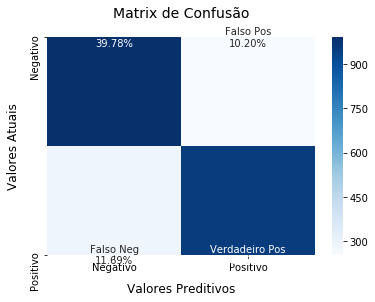

In [44]:
MNBmodel = MultinomialNB()
MNBmodel.fit(X_train, y_train)
Avalicao_Modelo(MNBmodel)

# <a name="p8-2">Modelo BernoulliNB</a>

              precision    recall  f1-score   support

    Negativo       0.70      0.78      0.74      1244
    Positivo       0.75      0.66      0.70      1245

    accuracy                           0.72      2489
   macro avg       0.72      0.72      0.72      2489
weighted avg       0.72      0.72      0.72      2489



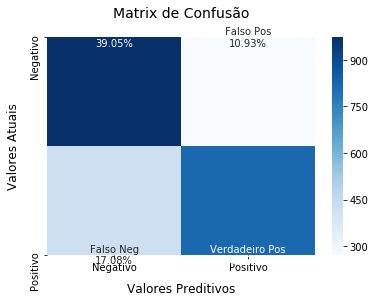

In [45]:
BNBmodel = BernoulliNB(alpha = 0.001)
BNBmodel.fit(X_train, y_train)
Avalicao_Modelo(BNBmodel)

# <a name="p8-3">Modelo LinearSVC</a>

              precision    recall  f1-score   support

    Negativo       0.80      0.78      0.79      1244
    Positivo       0.78      0.81      0.79      1245

    accuracy                           0.79      2489
   macro avg       0.79      0.79      0.79      2489
weighted avg       0.79      0.79      0.79      2489



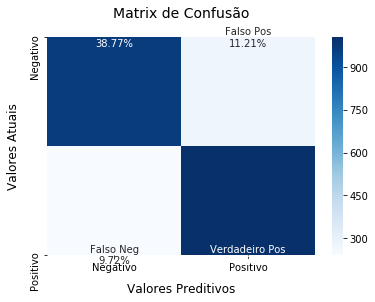

In [46]:
SVCmodel = LinearSVC(random_state=0, tol=1e-5)
SVCmodel.fit(X_train, y_train)
Avalicao_Modelo(SVCmodel)

# <a name="p9">Savando Modelos</a>

In [120]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-SVC.pickle','wb')
pickle.dump(SVCmodel, file)
file.close()

file = open('Sentiment-MNB.pickle','wb')
pickle.dump(MNBmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

# <a name="p10"> Usando os modelos</a>

In [121]:
def load_models():

    # Carregando o vectoriser.
    file = open('C:/Users/Hugo Mauad/Desktop/NPL/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Carregando o modelo SVC.
    file = open('C:/Users/Hugo Mauad/Desktop/NPL/Sentiment-SVC.pickle', 'rb')
    SVCmodel = pickle.load(file)
    file.close()
    # Carregando o modelo MNB.
    file = open('C:/Users/Hugo Mauad/Desktop/NPL/Sentiment-MNB.pickle', 'rb')
    MNBmodel = pickle.load(file)
    file.close()
    #Carregando o modelo BNB.
    file = open('C:/Users/Hugo Mauad/Desktop/NPL/Sentiment-BNB.pickle', 'rb')
    MNBmodel = pickle.load(file)
    file.close()
    
    return vectoriser, SVCmodel, MNBmodel, BNBmodel

def predict(vectoriser, model, text):
    # Pré processamento do texto
    Text1 = Replace_Normalization(Text)
    X_train_tokens1 = _tokenize_text(Text1)
    X_train_tokens2 = _apply_standardization(X_train_tokens1, std_list)
    X_train_tokens3 = _remove_stopwords(X_train_tokens2, stopwordlist)
    X_train_tokens4 = _apply_lemmatization(X_train_tokens3)
    X_train_tokens5 = _apply_stemmer(X_train_tokens4)
    X_novo = _untokenize_text(X_train_tokens5)
    
    textdata = vectoriser.transform(X_novo)
    sentiment = model.predict(textdata)
    
    # Fazendo uma lista dos sentimentos.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convertendo list para Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Carregando os modelos.
    #vectoriser, SVCmodel = load_models()
    
    # Análise de sentimento em um texto pequeno.
    text = ["O governo é muito ruim 😊",
          "Calamidade pública, péssimo esse governo",
          "A segurança desse país está ótima",
           "O prefeito está fazendo um trabalho muito bom"]
    
    df2 = predict(vectoriser, BNBmodel, text)
    print("BNBmodel")
    print(df2.head())
    df1 = predict(vectoriser, MNBmodel, text)
    print("MNBmodel")
    print(df1.head())
    df = predict(vectoriser, SVCmodel, text)
    print("SVCmodel")
    print(df.head())

BNBmodel
                                            text sentiment
0                       O governo é muito ruim 😊  Negativo
1       Calamidade pública, péssimo esse governo  Negativo
2              A segurança desse país está ótima  Positivo
3  O prefeito está fazendo um trabalho muito bom  Negativo
MNBmodel
                                            text sentiment
0                       O governo é muito ruim 😊  Negativo
1       Calamidade pública, péssimo esse governo  Negativo
2              A segurança desse país está ótima  Positivo
3  O prefeito está fazendo um trabalho muito bom  Positivo
SVCmodel
                                            text sentiment
0                       O governo é muito ruim 😊  Negativo
1       Calamidade pública, péssimo esse governo  Negativo
2              A segurança desse país está ótima  Positivo
3  O prefeito está fazendo um trabalho muito bom  Positivo


# <a name="p11"> Considerações finais</a>
1. O DataSet escolhido teve sua classificação dos sentimentos de forma extremamente simples. Utilizaram Querys de abordagem política brasileira e a classificação dos sentimentos através dos Emojis (Smile - sentimento Positivo, Sad - Sentimento Negativo). Para conseguir um DataMining do twitter mais fiel para o treinamento do nosso modelo existem biblioteca mais interessantes como **Sentiment140** para essa classificação, entretanto não é Open-Source. Assim, para projetos futuros pode ser uma biblioteca importante para as análises. 
2. Para não existir maior polarização em cima do nosso resultado, o emoji que foi utilizado para classificar os sentimentos inicial foi retirado.
3. O DataSet possui apenas 50.000 tweets, dentro de um universo polarizado. Assim, para sua aplicação deverá ser apenas aplicada dentro da categoria **Política brasileira**.
4. Os modelos utilizados são os mais comuns para NPL, ressaltando que o modelo SVC e modelo MultinomialNB obtiveram melhor resultado (f1 score). O modelo BernoulliNB na linha 4 do nosso texto de teste houve um **Falso Negativo** devido ao seu f1 score ser menor comparado aos outros.
5. Mesmo com as limitações do DataSet, após realizar o teste conseguimos retornar com resultados verdadeiros.